In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import lightgbm as lgb
from tqdm import tqdm


In [2]:
# Data cleansing v1
'''
id : 단순 id
url : 단순 url
title : purpose 칼럼에서 더 categorized 설명되는 내용
application_type : individual이 980개
next_pymnt_d : 칼럼이 비어 있음
policy_code : 값이 모두 1임
chargeoff_within_12_mths : 0이 995개
delinq_amnt : 0이 997개
num_tl_120dpd_2m : 0이 아닌 값이 딱 1개
num_tl_30dpd : 0이 아닌 값이 딱 2개
hardship_flag : 값이 모두 N
disbursement_method : cash가 997개
'''

df = pd.read_csv("lending_club_sample.csv")
df = df.drop(columns=["id",
                      "url",
                      "title",
                      "application_type",
                      "next_pymnt_d",
                      "policy_code",
                      "chargeoff_within_12_mths",
                      "delinq_amnt",
                      "num_tl_120dpd_2m",
                      "num_tl_30dpd",
                      "hardship_flag",
                      "disbursement_method"])

df.to_csv("data_preprocessed_v1.csv", index=False)

In [1]:
# Data cleansing v3
df = pd.read_csv("./data_preprocessed_v1.csv")

# grade, sub_grade
# categorical variable(ordinal variable) Labeling
# og_grade = df["grade"]
# og_sub_grade = df["sub_grade"]

grade = np.array(df["grade"])
sub_grade = np.array(df["sub_grade"])

encoder = LabelEncoder()
grade_encoded = encoder.fit_transform(grade)
sub_grade_encoded = encoder.fit_transform(sub_grade)

df["grade"] = grade_encoded
df["sub_grade"] = sub_grade_encoded

# data cleansing. drop columns which has under 50 datas
df = df.loc[:, df.count() >= 50]

# fico_range_low
# data cleansing. add avg fico score column 
insert_loc = df.columns.get_loc('fico_range_low')
df.insert(insert_loc, 'fico_avg', (df['fico_range_low'] + df['fico_range_high']) / 2)

# emp_length
# 2 way of emp_length mapping.
# emp_length이 NaN인 값(무직)을 -1로 매핑, 나머지를 오름차순으로 0~10
# emp_length이 NaN인 값(무직)을 -1로 매핑, 나머지를 오름차순으로 1~11. 무직과 고용상태를 구분하기 위함
label_mapping = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

df['emp_length'] = df['emp_length'].map(label_mapping)
df['emp_length'] = df['emp_length'].fillna(-1)

# term
# categorical variable Labeling
label_mapping = {
    ' 36 months': 36,
    ' 60 months': 60
}

df['term'] = df['term'].map(label_mapping)

# mths_since_last_delinq
# 최종 연체 후 경과 개월 수
# 연체가 있었는지 없었는지 binary로 구분하는 데이터로 사용하면 될듯
# 연체가 없었으면 0, 있었으면 1
insert_loc = df.columns.get_loc('mths_since_last_delinq')
df.insert(insert_loc, 'delinq_flag', np.where(df['mths_since_last_delinq'].isna(), 0, 1))

# mths_since_last_record
# 마지막 파산 기록 이후 경과된 개월 수
# 이거 유용한 정보인거 같긴 한데, 한국어 번역에 문제가 있는 것같다. 영어 원문에 public record라고 써있는데, public record는 파산을 포함한 공적 기록을 의미한다. 따라서 꼭 파산이 아닐 수도 있음.
# https://credit.org/blogs/blog-posts/understanding-your-public-record-information 해당 링크에 따르면, 판결 등의 정보도 public record에 포함된다.
# 일단 drop

# revol_util
# follow paper (Machine learning and artificial neural networks to construct P2P lending credit-scoring model: A case using Lending Club data), form change percentage form to decimal form
# 결측치는 평균값으로 채워넣는다
df['revol_util'] = df['revol_util'] / 100.0
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].mean())

# tot_coll_amt
# 총 채권 추심 금액
# 결측값만 처리
df["tot_coll_amt"] = df["tot_coll_amt"].fillna(0)

# tot_cur_bal
# 모든 계좌 현재 잔액 합계
# 결측값은 중앙값으로
df["tot_cur_bal"] = df["tot_cur_bal"].fillna(df["tot_cur_bal"].median())

# total_rev_hi_lim
# 리볼빙 총 한도
# 결측값은 중앙값으로
df["total_rev_hi_lim"] = df["total_rev_hi_lim"].fillna(df["total_rev_hi_lim"].median())

# acc_open_past_24mths
# 최근 24개월 동안 개설된 신용거래 건수
# 결측값은 중앙값으로
df["acc_open_past_24mths"] = df["acc_open_past_24mths"].fillna(df["acc_open_past_24mths"].median())

# avg_cur_bal
# 모든 계좌의 평균 현재 잔액
# 결측값은 중앙값으로
df["avg_cur_bal"] = df["avg_cur_bal"].fillna(df["avg_cur_bal"].median())

# bc_open_to_buy
# 리볼빙 은행카드 사용 가능 한도
# 결측값은 중앙값으로
df["bc_open_to_buy"] = df["bc_open_to_buy"].fillna(df["bc_open_to_buy"].median())

# bc_util
# 은행카드 한도 대비 잔액 비율
# 결측값은 평균값으로
df['bc_util'] = df['bc_util'] / 100.0
df['bc_util'] = df['bc_util'].fillna(df['bc_util'].mean())

# mort_acc
# 주택담보대출 계좌 수
# 결측값은 중앙값으로
df["mort_acc"] = df["mort_acc"].fillna(df["mort_acc"].median())

# num_accts_ever_120_pd
# 120일 이상 연체 경험 계좌 수
# 결측값은 중앙값으로
df["num_accts_ever_120_pd"] = df["num_accts_ever_120_pd"].fillna(df["num_accts_ever_120_pd"].median())

# num_actv_bc_tl
# num_actv_rev_tl
# num_bc_sats
# num_bc_tl
# num_il_tl
# num_op_rev_tl
# num_rev_accts
# num_rev_tl_bal_gt_0
# num_sats
# 다 현재 계좌 수에 관련된 칼럼. 나중에 보고 좀 합쳐야할듯
# 결측값은 중앙값으로
cols = [
    'num_actv_bc_tl',
    'num_actv_rev_tl',
    'num_bc_sats',
    'num_bc_tl',
    'num_il_tl',
    'num_op_rev_tl',
    'num_rev_accts',
    'num_rev_tl_bal_gt_0',
    'num_sats'
]

df[cols] = df[cols].fillna(df[cols].median())

# num_tl_90g_dpd_24m : 최근 24개월 90일 이상 연체 계좌 수
# num_tl_op_past_12m : 최근 12개월 개설 계좌 수
# tot_hi_cred_lim : 총 최고 신용 한도
# total_bal_ex_mort : 주택담보 제외 총 잔액
# total_bc_limit : 은행카드 총 한도
# total_il_high_credit_limit : 할부 계좌 총 한도
# 결측값은 중앙값으로
cols = [
    'num_tl_90g_dpd_24m',
    'num_tl_op_past_12m',
    'tot_hi_cred_lim',
    'total_bal_ex_mort',
    'total_bc_limit',
    'total_il_high_credit_limit'
]

df[cols] = df[cols].fillna(df[cols].median())

# pct_tl_nvr_dlq : 연체 경험 없는 계좌 비율
# percent_bc_gt_75 : 한도 75% 초과 은행카드 계좌 비율
# 결측값은 평균으로
cols = ['pct_tl_nvr_dlq', 'percent_bc_gt_75']

df[cols] = df[cols].fillna(df[cols].mean())

# loan_status : 부도 여부, 타겟 변수
# non-default = 0, default = 1
df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

# drop columns
'''
모델링을 위해 필요없어보이는 칼럼을 삭제. 추후에 재검토를 통해 살려서 다시 쓸 수도 있음
zip_code : 알아보니 zip_code 앞 3자리로는 state + city까지 알 수 있던데, 일단 addr_state에서 state는 알 수 있으니 탈락
fico_range_low : fico_range_high와 평균내어 fico_avg라는 파생변수로 만듬
desc : 대출 이유 설명 칸인데, nlp로 사용할 여지가 있긴 하지만 비어있는 칼럼 비율이 너무 높음. 92.7%
emp_title : 직업이 labeling하기 힘들 정도로 다양하기도 하고 근속 연수와 소득이 더 직관적인 데이터라고 생각해서 탈락
mths_since_last_delinq : 연체 여부를 판단하는 binary type 파생변수로 만듬. delinq_falg
mths_since_last_record : 일단 drop, 위 사유 참조
last_pymnt_d : 변수가 뭘 의미하는지 모르겠어서 일단 드랍. 시계열 데이터와 연관 있는거라면, 모델 개입 시점 때문에 탈락
mths_since_last_major_derog : 90일 이상 연체 여부인데, 연체 여부랑 크게 다를거 같지 않아서 일단 탈락
mo_sin_old_il_acct : 가장 오래된 계좌 개설 후 지난 시간. 일단 지우고 도메인팀 협의
mo_sin_old_rev_tl_op : 
mths_since_recent_bc : 최근 계좌 개설 후 지난 시간. 일단 지우고 도메인팀 협의 
mths_since_recent_bc_dlq : 
mths_since_recent_inq : 
mths_since_recent_revol_delinq : 
last_fico_range_high : 대출 신청 전 fico 점수가 따로 있음
last_fico_range_low : 
issue_d : 대출 실행 날짜. 시계열 데이터로 쓸 수 있겠으나 일단 드랍
purpose : 대출 실행 목적. NLP로 처리해야할듯. 일단 드랍
addr_state : 대출 실행시 거주 state
earliest_cr_line : 최초 신용계좌 계설일. 일단 드랍
initial_list_status : 최초 상장 날짜. 일단 드랍
last_credit_pull_d : LC가 최종적으로 신용 조회를 한 날짜. 일단 드랍
debt_settlement_flag : 채무 조정 프로그램에 참여한 상태인가 여부. debt_settlement_flag_date 와 연계해서 쓰면, 대출 실행 이전 시점 데이터를 추릴 수 있겠으나, debt_settlement_flag_date 칼럼이 데이터가 너무 적어서 같이 드랍해야될듯.
pymnt_plan : 값이 다 n임
mo_sin_rcnt_rev_tl_op : 최근 리볼빙 계좌 계설 경과일
mo_sin_rcnt_tl : 
'''
df = df.drop(columns=["zip_code",
                      "fico_range_low",
                      "fico_range_high",
                      "desc",
                      "emp_title",
                      "mths_since_last_delinq",
                      "mths_since_last_record",
                      "last_pymnt_d",
                      "mths_since_last_major_derog",
                      "mo_sin_old_il_acct",
                      "mo_sin_old_rev_tl_op",
                      "mths_since_recent_bc",
                      "mths_since_recent_bc_dlq",
                      "mths_since_recent_inq",
                      "mths_since_recent_revol_delinq",
                      "last_fico_range_high",
                      "last_fico_range_low",
                      "issue_d",
                      "purpose",
                      "addr_state",
                      "earliest_cr_line",
                      "initial_list_status",
                      "last_credit_pull_d",
                      "debt_settlement_flag",
                      "pymnt_plan",
                      "mo_sin_rcnt_rev_tl_op",
                      "mo_sin_rcnt_tl"
                      ])

# 30% 이상 결측치를 가지는 칼럼 drop
df = df.loc[:, df.isnull().mean() < 0.3]

df.to_csv("./data_preprocessed_v3.csv", index=False)

# View categorical columns

# df.select_dtypes(include=['object', 'category']).columns.tolist()
# df = df.drop(columns=df.select_dtypes(include=['object', 'category']).columns.tolist())
# df

# Qualitative var labeling(nominal var. without ordinal var)

df = pd.get_dummies(df, columns=["home_ownership", "verification_status"], drop_first=True)
df.to_csv("./data_preprocessed_v4.csv", index=False)
df["loan_status"].value_counts()

NameError: name 'pd' is not defined

In [25]:
# Feture selection
# 모델 개입 시점에 따르면, 대출 실행 전 신용도를 LC입장에서 자체 신용등급평가를 하게 됨.
# 신용등급과 대출 실행의 부산물인 int_rate는 grade와 매우 연관 깊음. 따라서 탈락시킴
# 타겟변수가 grade인 경우, sub_grade인 경우 두 가지를 테스트함
# df1 = df.drop(columns=['int_rate', 'sub_grade'])
# # df2 = df.drop(columns=['int_rate', 'grade'])
# 
# df1["grade"].value_counts()
# # df2["sub_grade"].value_counts()
# 
# # grade의 e, f, g등급 데이터 개수가 너무 적어 e등금 이하로 통합
# df1.loc[df['grade'].isin([5, 6]), 'grade'] = 4
# df1["grade"].value_counts()

In [5]:
# Data cleansing v5
# 채무불이행 이후에 발생하는 데이터를 가진 칼럼 삭제
df = pd.read_csv("./data_preprocessed_v4.csv")
df = df.drop(columns=["recoveries", "collection_recovery_fee", "collections_12_mths_ex_med", "tot_coll_amt", ])


In [6]:
# 데이터 준비
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# bool타입 정수형으로
# XGBoost가 bool type를 처리할 때 문제를 발생시키는 경우가 있음
bool_columns = X.select_dtypes(include=['bool']).columns.tolist()
X[bool_columns] = X[bool_columns].astype(int)

# 1️⃣ 먼저 Train(80%) / Test(20%) 로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2️⃣ Train 데이터에서 Validation(20%) 분리 (즉, Train 80% → Train 75%, Valid 25%)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2/0.8, random_state=42, stratify=y_train)

# 출력해서 확인
print(f"Train set size: {X_train.shape[0]} rows")
print(f"Validation set size: {X_valid.shape[0]} rows")
print(f"Test set size: {X_test.shape[0]} rows")


Train set size: 600 rows
Validation set size: 200 rows
Test set size: 200 rows


ExtraTreesClassifier Feature Importances:
                                Feature  Importance
24                      total_rec_prncp    0.145405
27                      last_pymnt_amnt    0.070364
22                          total_pymnt    0.063707
23                      total_pymnt_inv    0.062930
1                           funded_amnt    0.042892
0                             loan_amnt    0.040303
2                       funded_amnt_inv    0.038847
5                           installment    0.033768
3                                  term    0.029861
25                        total_rec_int    0.018030
7                             sub_grade    0.015589
4                              int_rate    0.015563
10                                  dti    0.012791
19                            total_acc    0.012668
17                            revol_bal    0.012479
18                           revol_util    0.011681
15                             open_acc    0.011413
6                     

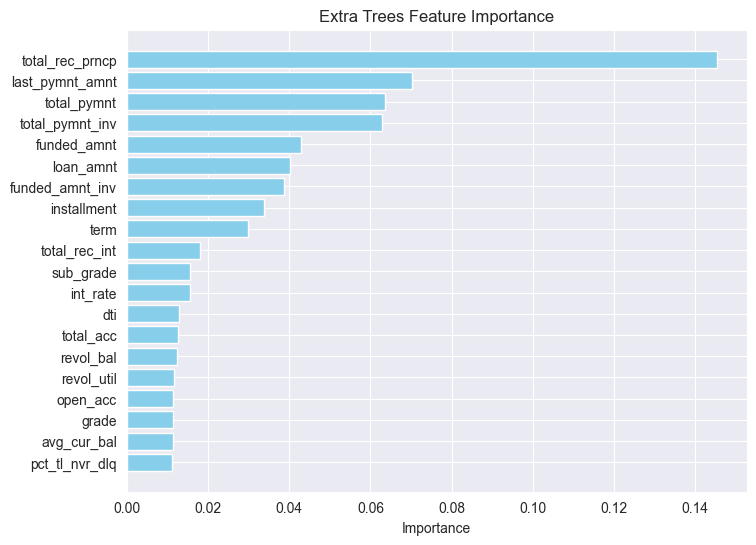

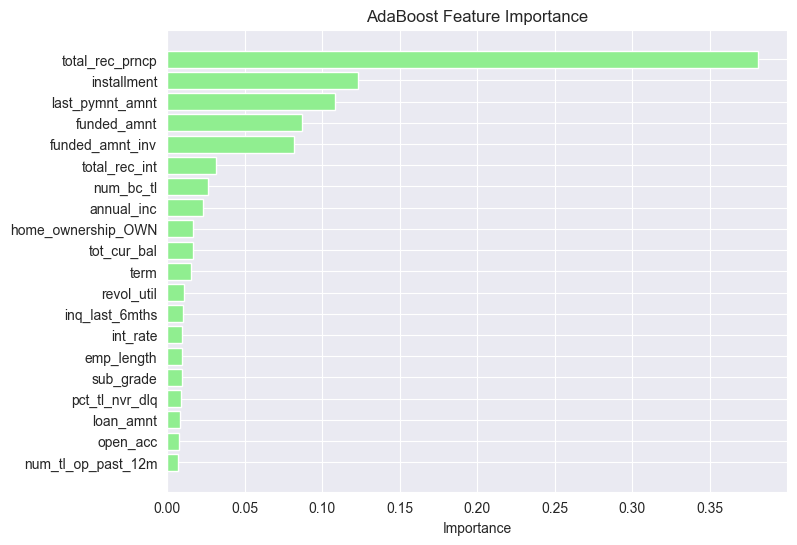

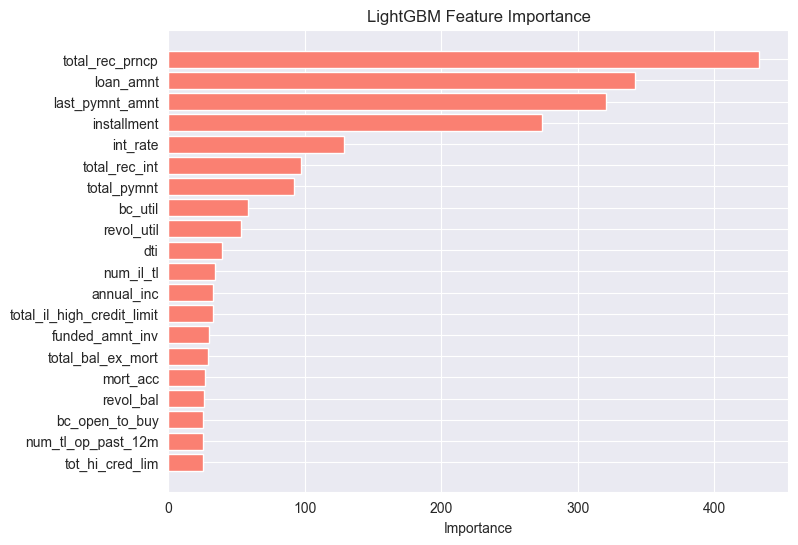

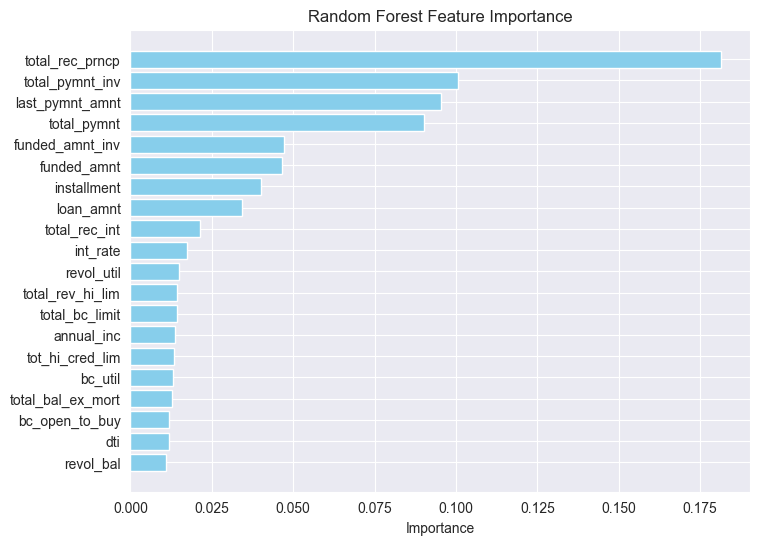

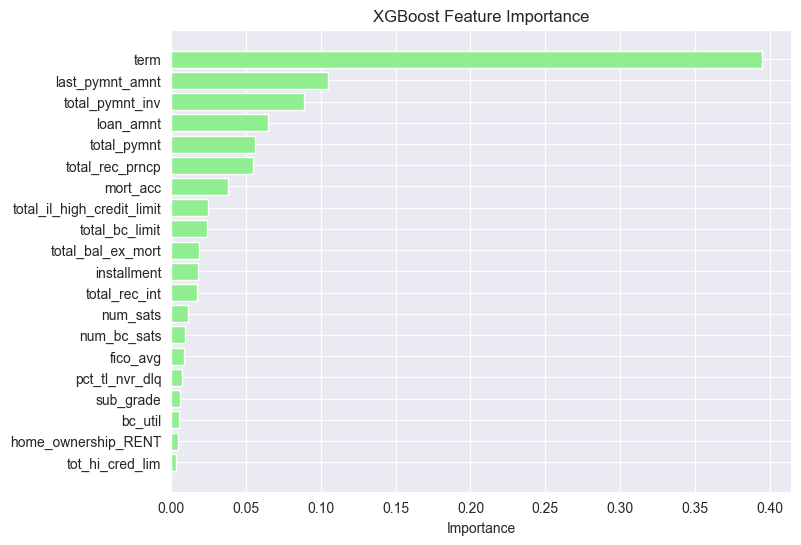

In [67]:
# --- Feature Importance 분석 ---
# 1. Extra Trees Classifier
etc = ExtraTreesClassifier(n_estimators=100, random_state=42)
etc.fit(X_train, y_train)
etc_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': etc.feature_importances_
}).sort_values(by='Importance', ascending=False)
    
print("ExtraTreesClassifier Feature Importances:")
print(etc_importance_df)

# 2. AdaBoost Classifier
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)
ada_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': ada.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("AdaBoost Classifier Feature Importances:")
print(ada_importance_df)

# 3. LightGBM Classifier
lgb_model = lgb.LGBMClassifier(random_state=42, force_col_wise=True)
lgb_model.fit(X_train, y_train)
lgb_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("LightGBM Classifier Feature Importances:")
print(lgb_importance_df)

# 4. RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importances:")
print(rf_importance_df)

# 5. XGBoost Classifier
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
xgb_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importances:")
print(xgb_importance_df)

# --- Feature Importance 시각화 ---
def plot_feature_importance(df, title, color='skyblue'):
    # 상위 20개 Feature만 선택
    df_top20 = df.head(20)
    plt.figure(figsize=(8, 6))
    plt.barh(df_top20['Feature'], df_top20['Importance'], color=color)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Importance")
    plt.show()

plot_feature_importance(etc_importance_df, "Extra Trees Feature Importance", 'skyblue')
plot_feature_importance(ada_importance_df, "AdaBoost Feature Importance", 'lightgreen')
plot_feature_importance(lgb_importance_df, "LightGBM Feature Importance", 'salmon')
plot_feature_importance(rf_importance_df, "Random Forest Feature Importance")
plot_feature_importance(xgb_importance_df, "XGBoost Feature Importance", 'lightgreen')


In [68]:
# Model running with selected feature
model_info = {
    'ExtraTrees': {
        'model': ExtraTreesClassifier(n_estimators=100, random_state=42),
        'importance_df': etc_importance_df
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(n_estimators=100, random_state=42),
        'importance_df': ada_importance_df
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(random_state=42, force_col_wise=True, verbose=-1),
        'importance_df': lgb_importance_df
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'importance_df': rf_importance_df
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='logloss'),
        'importance_df': xgb_importance_df
    }
}

results = {}

for model_name, info in model_info.items():
    clf = info['model']
    importance_df = info['importance_df']
    
    # 상위 20개 Feature 선택 (이미 내림차순 정렬되어 있다고 가정)
    top_features = importance_df['Feature'].head(30).tolist()
    
    # 선택된 Feature들만 사용해서 Train, Validation, Test 데이터셋 생성
    X_train_top = X_train[top_features]
    X_valid_top = X_valid[top_features]
    X_test_top  = X_test[top_features]
    
    # 해당 모델로 학습
    clf.fit(X_train_top, y_train)
    
    # 예측 및 정확도 평가
    y_valid_pred = clf.predict(X_valid_top)
    y_test_pred  = clf.predict(X_test_top)
    
    valid_acc = accuracy_score(y_valid, y_valid_pred)
    test_acc  = accuracy_score(y_test, y_test_pred)
    
    # 결과 저장
    results[model_name] = {
        'top_features': top_features,
        'valid_accuracy': valid_acc,
        'test_accuracy': test_acc
    }

# 각 모델별 결과 출력
for model_name, res in results.items():
    print(f"==== {model_name} 기반 상위 20 Feature 사용 ====")
    print("Top 20 Features:", res['top_features'])
    print(f"Validation Accuracy: {res['valid_accuracy']:.4f}")
    print(f"Test Accuracy: {res['test_accuracy']:.4f}")
    print("-"*50)


==== ExtraTrees 기반 상위 20 Feature 사용 ====
Top 20 Features: ['total_rec_prncp', 'last_pymnt_amnt', 'total_pymnt', 'total_pymnt_inv', 'funded_amnt', 'loan_amnt', 'funded_amnt_inv', 'installment', 'term', 'total_rec_int', 'sub_grade', 'int_rate', 'dti', 'total_acc', 'revol_bal', 'revol_util', 'open_acc', 'grade', 'avg_cur_bal', 'pct_tl_nvr_dlq', 'verification_status_Verified', 'num_sats', 'percent_bc_gt_75', 'emp_length', 'tot_hi_cred_lim', 'inq_last_6mths', 'num_rev_tl_bal_gt_0', 'tot_cur_bal', 'num_op_rev_tl', 'num_actv_rev_tl']
Validation Accuracy: 0.9650
Test Accuracy: 0.9800
--------------------------------------------------
==== AdaBoost 기반 상위 20 Feature 사용 ====
Top 20 Features: ['total_rec_prncp', 'installment', 'last_pymnt_amnt', 'funded_amnt', 'funded_amnt_inv', 'total_rec_int', 'num_bc_tl', 'annual_inc', 'home_ownership_OWN', 'tot_cur_bal', 'term', 'revol_util', 'inq_last_6mths', 'int_rate', 'emp_length', 'sub_grade', 'pct_tl_nvr_dlq', 'loan_amnt', 'open_acc', 'num_tl_op_past_12m

==== ExtraTrees 학습 곡선 시각화 ====


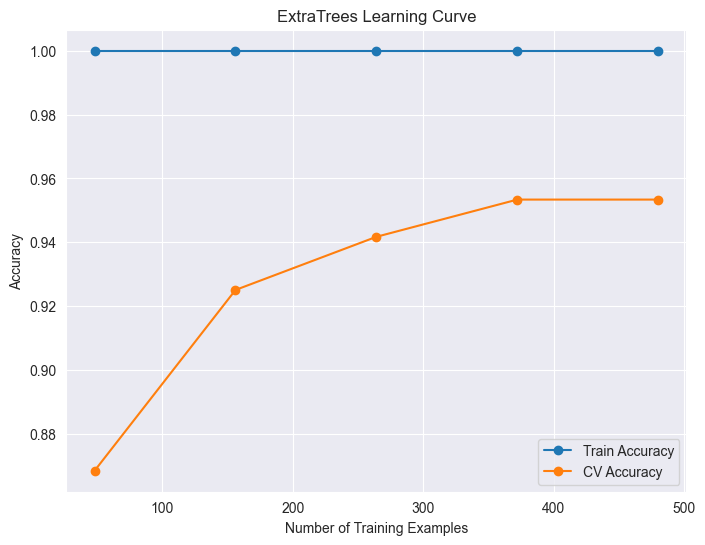

==== AdaBoost 학습 곡선 시각화 ====


C:\Users\user\Desktop\visualize-and-web\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\Desktop\visualize-and-web\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\Desktop\visualize-and-web\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\Desktop\visualize-and-web\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


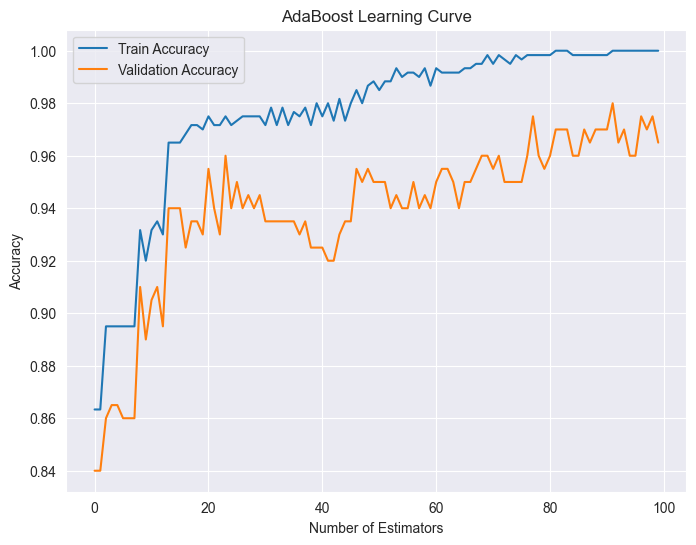

==== LightGBM 학습 곡선 시각화 ====


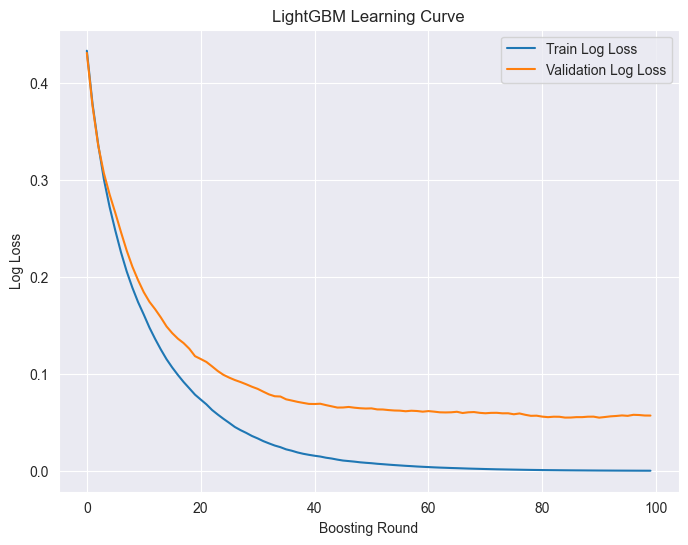

==== RandomForest 학습 곡선 시각화 ====


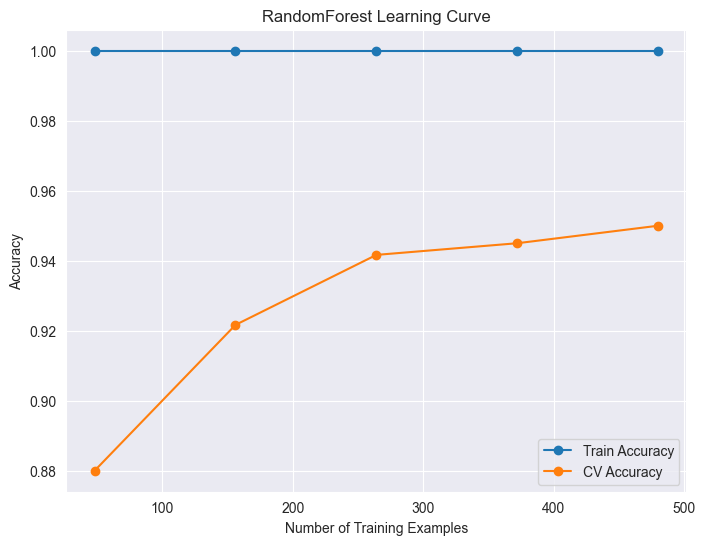

==== XGBoost 학습 곡선 시각화 ====


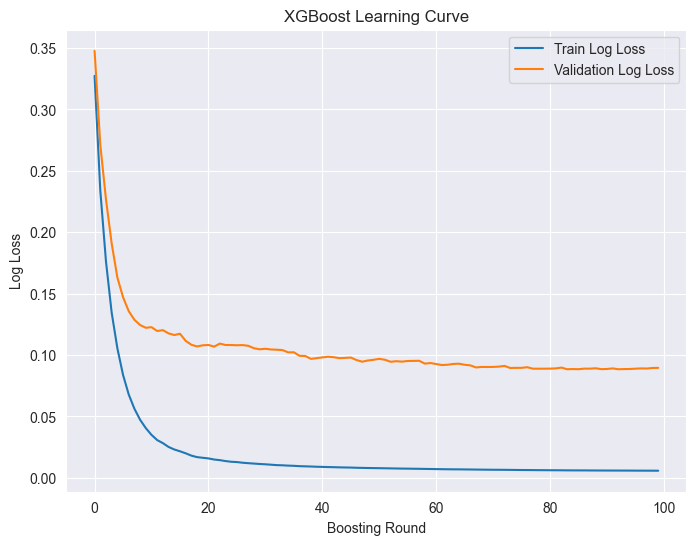

==== SVM 학습 곡선 시각화 ====


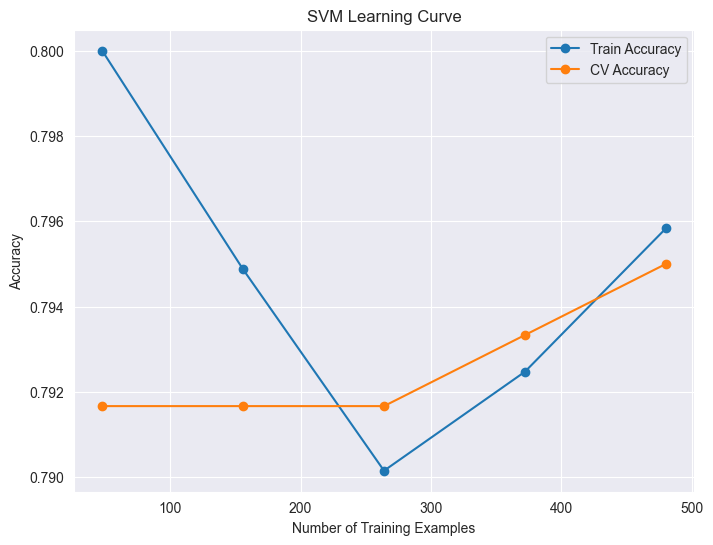

In [60]:
# 학습곡선 시각화
model_info = {
    'ExtraTrees': {
        'model': ExtraTreesClassifier(n_estimators=100, random_state=42),
        'importance_df': etc_importance_df
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(n_estimators=100, random_state=42),
        'importance_df': ada_importance_df
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(random_state=42, force_col_wise=True, verbose=-1),
        'importance_df': lgb_importance_df
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'importance_df': rf_importance_df
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='logloss'),
        'importance_df': xgb_importance_df
    },
}

# 각 모델별 학습 곡선을 시각화
for model_name, info in model_info.items():
    clf = info['model']
    importance_df = info['importance_df']
    
    # 상위 20개 Feature 선택 (이미 내림차순 정렬되어 있다고 가정)
    top_features = importance_df['Feature'].head(30).tolist()
    X_train_top = X_train[top_features]
    X_valid_top = X_valid[top_features]
    
    print(f"==== {model_name} 학습 곡선 시각화 ====")
    
    if model_name == 'AdaBoost':
        # AdaBoost는 staged_score를 제공함 (각 boosting round마다의 정확도를 기록)
        clf.fit(X_train_top, y_train)
        train_scores = list(clf.staged_score(X_train_top, y_train))
        valid_scores = list(clf.staged_score(X_valid_top, y_valid))
        plt.figure(figsize=(8,6))
        plt.plot(train_scores, label='Train Accuracy')
        plt.plot(valid_scores, label='Validation Accuracy')
        plt.xlabel('Number of Estimators')
        plt.ylabel('Accuracy')
        plt.title(f'{model_name} Learning Curve')
        plt.legend()
        plt.show()
    
    elif model_name == 'XGBoost':
        # XGBoost: use eval_set and evals_result to get learning curves (예: 로그 손실)
        eval_set = [(X_train_top, y_train), (X_valid_top, y_valid)]
        clf.fit(X_train_top, y_train, eval_set=eval_set, verbose=False)
        evals_result = clf.evals_result()
        epochs = len(evals_result['validation_0']['logloss'])
        x_axis = range(epochs)
        plt.figure(figsize=(8,6))
        plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Train Log Loss')
        plt.plot(x_axis, evals_result['validation_1']['logloss'], label='Validation Log Loss')
        plt.xlabel('Boosting Round')
        plt.ylabel('Log Loss')
        plt.title(f'{model_name} Learning Curve')
        plt.legend()
        plt.show()
    
    elif model_name == 'LightGBM':
        # LightGBM: use eval_set and evals_result_ (예: binary_logloss 사용, binary classification 가정)
        eval_set = [(X_train_top, y_train), (X_valid_top, y_valid)]
        clf.fit(X_train_top, y_train, eval_set=eval_set)
        evals_result = clf.evals_result_
        train_metric = evals_result['training']['binary_logloss']
        valid_metric = evals_result['valid_1']['binary_logloss']
        epochs = len(train_metric)
        x_axis = range(epochs)
        plt.figure(figsize=(8,6))
        plt.plot(x_axis, train_metric, label='Train Log Loss')
        plt.plot(x_axis, valid_metric, label='Validation Log Loss')
        plt.xlabel('Boosting Round')
        plt.ylabel('Log Loss')
        plt.title(f'{model_name} Learning Curve')
        plt.legend()
        plt.show()
    
    elif model_name in ['ExtraTrees', 'RandomForest']:
        # ExtraTrees와 RandomForest는 staged_score가 없으므로, learning_curve 함수를 사용
        train_sizes, train_scores, cv_scores = learning_curve(
            estimator=clf, 
            X=X_train_top, 
            y=y_train, 
            cv=5, 
            scoring='accuracy', 
            n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 5)
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        cv_scores_mean = np.mean(cv_scores, axis=1)
        plt.figure(figsize=(8,6))
        plt.plot(train_sizes, train_scores_mean, 'o-', label='Train Accuracy')
        plt.plot(train_sizes, cv_scores_mean, 'o-', label='CV Accuracy')
        plt.xlabel('Number of Training Examples')
        plt.ylabel('Accuracy')
        plt.title(f'{model_name} Learning Curve')
        plt.legend()
        plt.show()
    
    else:
        print(f"{model_name}의 학습 곡선 시각화 방법이 정의되어 있지 않습니다.")


In [66]:
# fdsa
model_info = {
    'ExtraTrees': {
        'model': ExtraTreesClassifier(n_estimators=100, random_state=42),
        'importance_df': etc_importance_df
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(n_estimators=100, random_state=42),
        'importance_df': ada_importance_df
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(random_state=42, force_col_wise=True, verbose=-1),
        'importance_df': lgb_importance_df
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'importance_df': rf_importance_df
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='logloss'),
        'importance_df': xgb_importance_df
    }
}

# StratifiedKFold 설정 (5-fold, 클래스 분포 유지)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 평가 지표들을 딕셔너리로 설정 (accuracy, precision, recall)
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall'
}

results_cv = {}

for model_name, info in model_info.items():
    clf = info['model']
    importance_df = info['importance_df']
    
    # 상위 20개 Feature 선택 (이미 내림차순 정렬되어 있다고 가정)
    top_features = importance_df['Feature'].head(20).tolist()
    X_train_top = X_train[top_features]
    
    # 3-fold 교차 검증 수행 (여러 지표 모두 반환)
    cv_results = cross_validate(
        estimator=clf,
        X=X_train_top,
        y=y_train,
        cv=kfold,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    
    results_cv[model_name] = cv_results
    print(f"==== {model_name} 교차 검증 결과 ====")
    
    # Validation 지표 (test_*) 결과
    acc = cv_results['test_accuracy']
    prec = cv_results['test_precision']
    rec = cv_results['test_recall']
    
    print("Validation Accuracy for each fold:", acc)
    print("Mean Validation Accuracy: {:.4f} (±{:.4f})".format(np.mean(acc), np.std(acc)))
    
    print("Validation Precision for each fold:", prec)
    print("Mean Validation Precision: {:.4f} (±{:.4f})".format(np.mean(prec), np.std(prec)))
    
    print("Validation Recall for each fold:", rec)
    print("Mean Validation Recall: {:.4f} (±{:.4f})".format(np.mean(rec), np.std(rec)))
    
    print("-" * 50)


==== ExtraTrees 교차 검증 결과 ====
Validation Accuracy for each fold: [0.96666667 0.95833333 0.95       0.99166667 0.975     ]
Mean Validation Accuracy: 0.9683 (±0.0143)
Validation Precision for each fold: [1. 1. 1. 1. 1.]
Mean Validation Precision: 1.0000 (±0.0000)
Validation Recall for each fold: [0.84 0.8  0.76 0.96 0.88]
Mean Validation Recall: 0.8480 (±0.0688)
--------------------------------------------------
==== AdaBoost 교차 검증 결과 ====
Validation Accuracy for each fold: [0.96666667 0.95       0.95       0.99166667 0.95833333]
Mean Validation Accuracy: 0.9633 (±0.0155)
Validation Precision for each fold: [1.         1.         1.         1.         0.95454545]
Mean Validation Precision: 0.9909 (±0.0182)
Validation Recall for each fold: [0.84 0.76 0.76 0.96 0.84]
Mean Validation Recall: 0.8320 (±0.0733)
--------------------------------------------------
==== LightGBM 교차 검증 결과 ====
Validation Accuracy for each fold: [0.96666667 0.975      0.95833333 0.99166667 0.98333333]
Mean Validatio

In [32]:
# model_info 딕셔너리: SVM 항목을 SVC로 변경
model_info = {
    'ExtraTrees': {
        'model': ExtraTreesClassifier(n_estimators=100, random_state=42),
        'importance_df': etc_importance_df
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(n_estimators=100, random_state=42),
        'importance_df': ada_importance_df
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(random_state=42, force_col_wise=True, verbose=-1),
        'importance_df': lgb_importance_df
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'importance_df': rf_importance_df
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='logloss'),
        'importance_df': xgb_importance_df
    }
}

# 각 모델별 하이퍼파라미터 그리드 설정
param_grids = {
    'ExtraTrees': {
         'n_estimators': [50, 100, 200, 300, 400, 500],
         'max_depth': [None, 10, 15, 20]
    },
    'AdaBoost': {
         'n_estimators': [50, 100, 200],
         'learning_rate': [0.1, 0.5, 1.0]
    },
    'LightGBM': {
         'n_estimators': [50, 100, 200],
         'max_depth': [None, 3, 5, 7, 10]
    },
    'RandomForest': {
         'n_estimators': [50, 100, 200, 300, 400, 500],
         'max_depth': [None, 10, 15, 20]
    },
    'XGBoost': {
         'n_estimators': [50, 100, 200],
         'max_depth': [3, 5, 7, 10],
         'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]
    }
}

# 5-fold StratifiedKFold (클래스 분포 유지)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

# 각 모델에 대해 Grid Search 수행
for model_name, info in tqdm(model_info.items(), desc="Models", unit="model"):
    print(f"\n==== {model_name} Grid Search ====")
    clf = info['model']
    importance_df = info['importance_df']
    
    # 각 모델별 top 20 feature 선택 (이미 내림차순 정렬되어 있다고 가정)
    top_features = importance_df['Feature'].head(20).tolist()
    print("Top 20 Features:", top_features)
    
    # top20 feature만 사용하여 데이터셋 구성
    X_train_top = X_train[top_features]
    X_valid_top = X_valid[top_features]
    X_test_top  = X_test[top_features]
    
    # 해당 모델에 맞는 하이퍼파라미터 그리드 추출
    param_grid = param_grids.get(model_name, {})
    
    # GridSearchCV 설정 (진행 상황을 볼 수 있도록 verbose=1)
    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    
    # Grid Search 수행 (train 데이터 사용)
    grid_search.fit(X_train_top, y_train)
    
    best_params = grid_search.best_params_
    best_cv_score = grid_search.best_score_
    print("Best Parameters:", best_params)
    print("Best CV Accuracy: {:.4f}".format(best_cv_score))
    
    # 최적의 모델(best estimator)으로 전체 train 데이터 재학습
    best_model = grid_search.best_estimator_
    best_model.fit(X_train_top, y_train)
    
    # Validation 및 Test set 평가
    y_valid_pred = best_model.predict(X_valid_top)
    y_test_pred  = best_model.predict(X_test_top)
    
    valid_acc = accuracy_score(y_valid, y_valid_pred)
    test_acc  = accuracy_score(y_test, y_test_pred)
    
    print("Validation Accuracy: {:.4f}".format(valid_acc))
    print("Test Accuracy: {:.4f}".format(test_acc))
    
    print("\nTest Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_test_pred))
    print("-" * 50)
    
    # 결과 저장
    results[model_name] = {
        'best_params': best_params,
        'best_cv_score': best_cv_score,
        'valid_accuracy': valid_acc,
        'test_accuracy': test_acc,
        'confusion_matrix': confusion_matrix(y_test, y_test_pred),
        'classification_report': classification_report(y_test, y_test_pred, output_dict=True)
    }


Models:   0%|          | 0/6 [00:00<?, ?model/s]


==== ExtraTrees Grid Search ====
Top 20 Features: ['total_rec_prncp', 'last_pymnt_amnt', 'total_pymnt', 'total_pymnt_inv', 'funded_amnt', 'loan_amnt', 'funded_amnt_inv', 'installment', 'term', 'total_rec_int', 'sub_grade', 'int_rate', 'dti', 'total_acc', 'revol_bal', 'revol_util', 'open_acc', 'grade', 'avg_cur_bal', 'pct_tl_nvr_dlq']
Fitting 5 folds for each of 24 candidates, totalling 120 fits


Models:  17%|█▋        | 1/6 [00:10<00:50, 10.10s/model]

Best Parameters: {'max_depth': None, 'n_estimators': 50}
Best CV Accuracy: 0.9683
Validation Accuracy: 0.9650
Test Accuracy: 0.9800

Test Confusion Matrix:
[[158   0]
 [  4  38]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       158
           1       1.00      0.90      0.95        42

    accuracy                           0.98       200
   macro avg       0.99      0.95      0.97       200
weighted avg       0.98      0.98      0.98       200

--------------------------------------------------

==== AdaBoost Grid Search ====
Top 20 Features: ['total_rec_prncp', 'installment', 'last_pymnt_amnt', 'funded_amnt', 'funded_amnt_inv', 'total_rec_int', 'num_bc_tl', 'annual_inc', 'home_ownership_OWN', 'tot_cur_bal', 'term', 'revol_util', 'inq_last_6mths', 'int_rate', 'emp_length', 'sub_grade', 'pct_tl_nvr_dlq', 'loan_amnt', 'open_acc', 'num_tl_op_past_12m']
Fitting 5 folds for each of 9 candidates, totalling 

Models:  33%|███▎      | 2/6 [00:13<00:25,  6.35s/model]

Validation Accuracy: 0.9700
Test Accuracy: 0.9900

Test Confusion Matrix:
[[158   0]
 [  2  40]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       158
           1       1.00      0.95      0.98        42

    accuracy                           0.99       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.99      0.99       200

--------------------------------------------------

==== LightGBM Grid Search ====
Top 20 Features: ['total_rec_prncp', 'loan_amnt', 'last_pymnt_amnt', 'installment', 'int_rate', 'total_rec_int', 'total_pymnt', 'bc_util', 'revol_util', 'dti', 'num_il_tl', 'annual_inc', 'total_il_high_credit_limit', 'funded_amnt_inv', 'total_bal_ex_mort', 'mort_acc', 'revol_bal', 'bc_open_to_buy', 'num_tl_op_past_12m', 'tot_hi_cred_lim']
Fitting 5 folds for each of 15 candidates, totalling 75 fits


Models:  50%|█████     | 3/6 [00:18<00:16,  5.66s/model]

Best Parameters: {'max_depth': None, 'n_estimators': 200}
Best CV Accuracy: 0.9767
Validation Accuracy: 0.9800
Test Accuracy: 0.9850

Test Confusion Matrix:
[[157   1]
 [  2  40]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       158
           1       0.98      0.95      0.96        42

    accuracy                           0.98       200
   macro avg       0.98      0.97      0.98       200
weighted avg       0.98      0.98      0.98       200

--------------------------------------------------

==== RandomForest Grid Search ====
Top 20 Features: ['total_rec_prncp', 'total_pymnt_inv', 'last_pymnt_amnt', 'total_pymnt', 'funded_amnt_inv', 'funded_amnt', 'installment', 'loan_amnt', 'total_rec_int', 'int_rate', 'revol_util', 'total_rev_hi_lim', 'total_bc_limit', 'annual_inc', 'tot_hi_cred_lim', 'bc_util', 'total_bal_ex_mort', 'bc_open_to_buy', 'dti', 'revol_bal']
Fitting 5 folds for each of 24 candidates

Models:  67%|██████▋   | 4/6 [00:32<00:18,  9.01s/model]

Best Parameters: {'max_depth': 10, 'n_estimators': 50}
Best CV Accuracy: 0.9567
Validation Accuracy: 0.9450
Test Accuracy: 0.9600

Test Confusion Matrix:
[[158   0]
 [  8  34]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       158
           1       1.00      0.81      0.89        42

    accuracy                           0.96       200
   macro avg       0.98      0.90      0.94       200
weighted avg       0.96      0.96      0.96       200

--------------------------------------------------

==== XGBoost Grid Search ====
Top 20 Features: ['term', 'last_pymnt_amnt', 'total_pymnt_inv', 'loan_amnt', 'total_pymnt', 'total_rec_prncp', 'mort_acc', 'total_il_high_credit_limit', 'total_bc_limit', 'total_bal_ex_mort', 'installment', 'total_rec_int', 'num_sats', 'num_bc_sats', 'fico_avg', 'pct_tl_nvr_dlq', 'sub_grade', 'bc_util', 'home_ownership_RENT', 'tot_hi_cred_lim']
Fitting 5 folds for each of 60 candida

Models:  83%|████████▎ | 5/6 [00:39<00:08,  8.32s/model]

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best CV Accuracy: 0.9667
Validation Accuracy: 0.9600
Test Accuracy: 0.9850

Test Confusion Matrix:
[[158   0]
 [  3  39]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       158
           1       1.00      0.93      0.96        42

    accuracy                           0.98       200
   macro avg       0.99      0.96      0.98       200
weighted avg       0.99      0.98      0.98       200

--------------------------------------------------

==== SVM Grid Search ====
Top 20 Features: ['total_rec_prncp', 'total_rec_int', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'last_pymnt_amnt', 'fico_avg', 'total_pymnt_inv', 'total_pymnt', 'avg_cur_bal', 'pct_tl_nvr_dlq', 'total_bc_limit', 'bc_open_to_buy', 'revol_bal', 'percent_bc_gt_75', 'installment', 'term', 'total_rev_hi_lim', 'tot_cur_bal', 'dti']
Fitting 5 folds for each of 30 cand

Models: 100%|██████████| 6/6 [00:42<00:00,  7.04s/model]

Best Parameters: {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Accuracy: 0.9800
Validation Accuracy: 0.9800
Test Accuracy: 0.9700

Test Confusion Matrix:
[[158   0]
 [  6  36]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       158
           1       1.00      0.86      0.92        42

    accuracy                           0.97       200
   macro avg       0.98      0.93      0.95       200
weighted avg       0.97      0.97      0.97       200

--------------------------------------------------
